# Billing Anomaly Detection Analysis

![Python](https://img.shields.io/badge/Python-3.11-green)
![Data Analysis](https://img.shields.io/badge/Type-EDA%20%26%20ML-orange)

---

### 🎯 **Objective**
Analyze billing data to identify patterns, data quality issues, and potential revenue leakage through anomaly detection techniques.

### 📊 **Analysis Scope**
1. **Import Required Libraries** - Setting up the analysis environment
2. **Load and Explore Billing Data** - Understanding the billing dataset structure
3. **Data Quality Assessment and Cleaning** - Identifying and fixing data issues
4. **Feature Selection for Anomaly Detection** - Choosing relevant fields for ML models
5. **Exploratory Data Analysis (EDA)** - Discovering patterns, distributions, and business insights
6. **Data Preprocessing and Feature Engineering** - Optimizing features for anomaly detection

### 🏢 **Revenue Leakage Sources**
Billing anomalies typically occur through:
- **Pricing Errors** - Incorrect unit prices or quantity calculations
- **Tax Miscalculations** - Wrong tax rates or computation errors  
- **System Glitches** - Processing errors in high-volume transactions
- **Data Inconsistencies** - Mismatched values between related billing fields

### 🔬 **Technical Approach**

**Data Analysis Methods:**
- Statistical profiling (mean, median, variance, outliers)
- Correlation analysis and multicollinearity detection
- Business logic validation and consistency checks

**Feature Engineering:**
- Derived validation features (price consistency, tax accuracy)
- Statistical transformations (Z-scores, percentiles)
- Categorical encoding and temporal feature extraction
- Intelligent feature prioritization (15 most relevant features)

**Anomaly Detection Preparation:**
- Standardized scaling for ML algorithms
- Low-variance feature removal
- Business-priority feature selection

## 1. Import Required Libraries

In [49]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Statistical analysis
from scipy.stats import zscore

# Set random seeds for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("✅ All libraries imported successfully!")
print(f"📊 Using pandas version: {pd.__version__}")
print(f"🧮 Using numpy version: {np.__version__}")
print(f"🎨 Using matplotlib version: {plt.matplotlib.__version__}")
print(f"🤖 Using scikit-learn version: {sklearn.__version__}")

✅ All libraries imported successfully!
📊 Using pandas version: 2.3.2
🧮 Using numpy version: 2.3.3
🎨 Using matplotlib version: 3.10.6
🤖 Using scikit-learn version: 1.7.2


## 2. Load and Explore Billing Data

Load the billing data and perform initial exploration to understand the dataset structure.

In [50]:
# Load the billing data
try:
    df = pd.read_csv('billing_data.csv')
    print("✅ Data loaded successfully!")
    print(f"📊 Dataset shape: {df.shape}")
    
except FileNotFoundError:
    print("❌ Error: billing_data.csv not found!")
    print("📂 Please ensure the file is in the same directory as this notebook")

# Display basic information about the dataset
print(f"\n📋 Dataset Overview:")
print(f"{'='*50}")
print(f"Number of records: {len(df):,}")
print(f"Number of columns: {len(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\n🔍 Column Information:")
print(df.dtypes)

print(f"\n📅 Date Range:")
if 'invoice_date' in df.columns:
    print(f"\n{df['invoice_date'].min()} to {df['invoice_date'].max()}")

print(f"\n📊 Sample Records:")
display(df.head())

✅ Data loaded successfully!
📊 Dataset shape: (10000, 14)

📋 Dataset Overview:
Number of records: 10,000
Number of columns: 14
Memory usage: 5.40 MB

🔍 Column Information:
invoice_id           object
customer_id          object
country              object
currency             object
invoice_date         object
product_id           object
service_category     object
quantity              int64
unit_price          float64
net_value           float64
tax_rate            float64
tax_amount          float64
total_amount        float64
invoice_status       object
dtype: object

📅 Date Range:

2024-01-01 to 2025-09-30

📊 Sample Records:


,invoice_id,customer_id,country,currency,invoice_date,product_id,service_category,quantity,unit_price,net_value,tax_rate,tax_amount,total_amount,invoice_status
0,INV-2024-000001,CUST-2824-IND,DE,EUR,2024-07-01,TAB-MINI,Tablet,4,1101.21,4404.84,0.19,836.92,5241.76,Cancelled
1,INV-2025-000002,CUST-5506-IND,IN,INR,2025-07-01,SWT-PRO,Smartwatch,22,568.00,12496.00,0.18,2249.28,14745.28,Cancelled
2,INV-2024-000003,CUST-4657-IND,AU,AUD,2024-02-06,HPH-NC,Headphones,20,295.05,5901.00,0.10,590.10,6491.10,Disputed
3,INV-2024-000004,CUST-2679-ENT,CA,CAD,2024-01-14,CAM-4K,Camera,9,425.24,3827.16,0.13,497.53,4324.69,Paid
4,INV-2025-000005,CUST-9935-IND,US,USD,2025-09-26,LAP-GAMER,Laptop,2,1097.94,2195.88,0.08,175.67,2371.55,Paid


## 3. Data Quality Assessment and Cleaning

In [51]:
print("🔍 Data Quality Assessment")
print("="*60)

# 1. Missing Values Analysis
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

missing_summary = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percentage
}).sort_values('Missing Count', ascending=False)

print(missing_summary[missing_summary['Missing Count'] > 0])

if missing_summary['Missing Count'].sum() == 0:
    print("✅ No missing values found!")
else:
    print(f"⚠️ Total missing values: {missing_summary['Missing Count'].sum()}")

# 2. Duplicate Records Analysis
print(f"\n📝 Duplicate Records Analysis:")
duplicates = df.duplicated()
print(f"Number of duplicate records: {duplicates.sum()}")
if duplicates.sum() > 0:
    print("❌ Duplicate records found - needs cleaning")
    # Remove duplicates
    df = df.drop_duplicates()
    print(f"✅ Removed duplicates. New shape: {df.shape}")
else:
    print("✅ No duplicate records found")

# 3. Data Type Issues
print(f"\n🔢 Data Type Analysis:")
numeric_columns = ['quantity', 'unit_price', 'net_value', 'tax_rate', 'tax_amount', 'total_amount']

for col in numeric_columns:
    if col in df.columns:
        # Check if column can be converted to numeric
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            non_numeric = df[col].isnull().sum()
            if non_numeric > 0:
                print(f"⚠️ {col}: {non_numeric} non-numeric values converted to NaN")
            else:
                print(f"✅ {col}: All values are numeric")
        except:
            print(f"❌ {col}: Cannot convert to numeric")

# 4. Logic Validation
print(f"\n💼 Business Logic Validation:")

# Check for negative quantities
negative_qty = (df['quantity'] < 0).sum() if 'quantity' in df.columns else 0
print(f"❌ Negative quantities: {negative_qty}")

# Check for negative unit prices
negative_price = (df['unit_price'] < 0).sum() if 'unit_price' in df.columns else 0
print(f"❌ Negative unit prices: {negative_price}")

# Check for zero amounts where there shouldn't be
zero_amounts = (df['total_amount'] <= 0).sum() if 'total_amount' in df.columns else 0
print(f"❌ Zero or negative total amounts: {zero_amounts}")

# Check tax rate consistency
if 'tax_rate' in df.columns:
    unusual_tax = ((df['tax_rate'] < 0) | (df['tax_rate'] > 0.3)).sum()
    print(f"⚠️ Unusual tax rates (<0% or >30%): {unusual_tax}")

# 5. Statistical Outliers Detection
print(f"\n📈 Statistical Outliers (using IQR method):")

def detect_outliers_iqr(data, column):
    """Detect outliers using Interquartile Range method"""
    if column not in data.columns:
        return 0
    
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((data[column] < lower_bound) | (data[column] > upper_bound)).sum()
    return outliers

outlier_columns = ['unit_price', 'quantity', 'total_amount', 'net_value', 'tax_rate', 'tax_amount']
for col in outlier_columns:
    if col in df.columns:
        outliers = detect_outliers_iqr(df, col)
        print(f"📊 {col}: {outliers} outliers ({outliers/len(df)*100:.1f}%)")

# Create data quality summary
print(f"\n📋 Data Quality Summary:")
print("="*40)

quality_issues = []
if negative_qty > 0:
    quality_issues.append(f"• {negative_qty} negative quantities")
if negative_price > 0:
    quality_issues.append(f"• {negative_price} negative prices")
if zero_amounts > 0:
    quality_issues.append(f"• {zero_amounts} zero/negative amounts")

if quality_issues:
    print("⚠️ Issues Found:")
    for issue in quality_issues:
        print(f"   {issue}")
else:
    print("✅ No major data quality issues found!")

print(f"\n📊 Dataset ready for analysis: {df.shape[0]:,} records, {df.shape[1]} columns")

🔍 Data Quality Assessment
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []
✅ No missing values found!

📝 Duplicate Records Analysis:
Number of duplicate records: 0
✅ No duplicate records found

🔢 Data Type Analysis:
✅ quantity: All values are numeric
✅ unit_price: All values are numeric
✅ net_value: All values are numeric
✅ tax_rate: All values are numeric
✅ tax_amount: All values are numeric
✅ total_amount: All values are numeric

💼 Business Logic Validation:
❌ Negative quantities: 0
❌ Negative unit prices: 0
❌ Zero or negative total amounts: 0
⚠️ Unusual tax rates (<0% or >30%): 0

📈 Statistical Outliers (using IQR method):
📊 unit_price: 259 outliers (2.6%)
📊 quantity: 637 outliers (6.4%)
📊 total_amount: 325 outliers (3.2%)
📊 net_value: 322 outliers (3.2%)
📊 tax_rate: 0 outliers (0.0%)
📊 tax_amount: 525 outliers (5.2%)

📋 Data Quality Summary:
✅ No major data quality issues found!

📊 Dataset ready for analysis: 10,000 records, 14 columns


## 4. Feature Selection for Anomaly Detection

Identify and select the most relevant features for detecting revenue leakage in billing data.

In [52]:
# Feature selection for anomaly detection
print("🎯 Feature Selection for Revenue Leakage Detection")
print("="*60)

# Define feature categories
feature_categories = {
    'Core Billing Features': [
        'quantity', 'unit_price', 'net_value', 'tax_amount', 'total_amount'
    ],
    'Tax & Compliance Features': [
        'tax_rate', 'invoice_date'
    ],
    'Categorical Features': [
        'service_category', 'country', 'currency', 'invoice_status'
    ],
    'Identifier Features': [
        'invoice_id', 'customer_id', 'product_id'
    ]
}

# Check which features are available in our dataset
available_features = {}
missing_features = {}

for category, features in feature_categories.items():
    available = [f for f in features if f in df.columns]
    missing = [f for f in features if f not in df.columns]
    
    available_features[category] = available
    missing_features[category] = missing
    
    print(f"\n📊 {category}:")
    if available:
        print(f"   ✅ Available: {', '.join(available)}")
    if missing:
        print(f"   ❌ Missing: {', '.join(missing)}")

# Create final feature list for anomaly detection
anomaly_detection_features = []
for features in available_features.values():
    anomaly_detection_features.extend(features)

# Remove temporal features from the main list (will handle separately)
if 'invoice_date' in anomaly_detection_features:
    anomaly_detection_features.remove('invoice_date')

print(f"\n🎯 Selected Features for Anomaly Detection:")
print(f"{'='*50}")
print(f"Total features: {len(anomaly_detection_features)}")
print(f"Features: {', '.join(anomaly_detection_features)}")

# Analyze feature completeness and quality
print(f"\n📊 Feature Quality Analysis:")
feature_quality = pd.DataFrame({
    'Feature': anomaly_detection_features,
    'Data Type': [str(df[f].dtype) for f in anomaly_detection_features],
    'Missing %': [df[f].isnull().sum() / len(df) * 100 for f in anomaly_detection_features],
    'Unique Values': [df[f].nunique() for f in anomaly_detection_features],
    'Zero Values': [sum(df[f] == 0) if df[f].dtype in ['int64', 'float64'] else 'N/A' for f in anomaly_detection_features]
})

display(feature_quality)

# Identify potential issues
print(f"\n⚠️ Feature Quality Issues:")
quality_issues = []

for _, row in feature_quality.iterrows():
    feature = row['Feature']
    missing_pct = row['Missing %']
    unique_vals = row['Unique Values']
    
    if missing_pct > 5:
        quality_issues.append(f"• {feature}: {missing_pct:.1f}% missing values")
    
    if row['Data Type'] in ['int64', 'float64'] and unique_vals == 1:
        quality_issues.append(f"• {feature}: Only 1 unique value (constant)")
    
    if row['Zero Values'] != 'N/A' and row['Zero Values'] > len(df) * 0.1:
        quality_issues.append(f"• {feature}: {row['Zero Values']} zero values ({row['Zero Values']/len(df)*100:.1f}%)")

if quality_issues:
    for issue in quality_issues:
        print(f"   {issue}")
else:
    print("✅ All selected features have good quality!")

# Create a cleaned dataset with selected features
print(f"\n🧹 Creating Clean Dataset:")

# Start with the selected features
anomaly_df = df[anomaly_detection_features].copy()
initial_records = len(anomaly_df)
anomaly_df = anomaly_df.dropna()
final_records = len(anomaly_df)

if initial_records != final_records:
    print(f"📊 Removed {initial_records - final_records} records with missing values")

# Create additional derived features for better anomaly detection
print(f"\n🔧 Creating Derived Features:")

# Price per unit validation (for multi-quantity orders)
if 'net_value' in anomaly_df.columns and 'quantity' in anomaly_df.columns and 'unit_price' in anomaly_df.columns:
    anomaly_df['calculated_gross'] = anomaly_df['quantity'] * anomaly_df['unit_price']
    anomaly_df['gross_amount_diff'] = abs(anomaly_df['net_value'] - anomaly_df['calculated_gross'])
    print("✅ Added gross amount validation features")

# Tax validation
if 'tax_amount' in anomaly_df.columns and 'net_value' in anomaly_df.columns and 'tax_rate' in anomaly_df.columns:
    anomaly_df['calculated_tax'] = anomaly_df['net_value'] * anomaly_df['tax_rate']
    anomaly_df['tax_amount_diff'] = abs(anomaly_df['tax_amount'] - anomaly_df['calculated_tax'])
    print("✅ Added tax validation features")

# Total amount validation
if 'total_amount' in anomaly_df.columns and 'net_value' in anomaly_df.columns and 'tax_amount' in anomaly_df.columns:
    anomaly_df['calculated_total'] = anomaly_df['net_value'] + anomaly_df['tax_amount']
    anomaly_df['total_amount_diff'] = abs(anomaly_df['total_amount'] - anomaly_df['calculated_total'])
    print("✅ Added total amount validation features")

print(f"\n📊 Final Dataset for Anomaly Detection:")
print(f"Records: {len(anomaly_df):,}")
print(f"Features: {len(anomaly_df.columns)}")

print(f"\n📋 Feature Summary:")
print(anomaly_df.dtypes)

🎯 Feature Selection for Revenue Leakage Detection

📊 Core Billing Features:
   ✅ Available: quantity, unit_price, net_value, tax_amount, total_amount

📊 Tax & Compliance Features:
   ✅ Available: tax_rate, invoice_date

📊 Categorical Features:
   ✅ Available: service_category, country, currency, invoice_status

📊 Identifier Features:
   ✅ Available: invoice_id, customer_id, product_id

🎯 Selected Features for Anomaly Detection:
Total features: 13
Features: quantity, unit_price, net_value, tax_amount, total_amount, tax_rate, service_category, country, currency, invoice_status, invoice_id, customer_id, product_id

📊 Feature Quality Analysis:


,Feature,Data Type,Missing %,Unique Values,Zero Values
0,quantity,int64,0.0,50,0
1,unit_price,float64,0.0,9695,0
2,net_value,float64,0.0,9925,0
3,tax_amount,float64,0.0,9719,0
4,total_amount,float64,0.0,9964,0
5,tax_rate,float64,0.0,6,0
6,service_category,object,0.0,10,N/A
7,country,object,0.0,9,N/A
8,currency,object,0.0,8,N/A
9,invoice_status,object,0.0,4,N/A



⚠️ Feature Quality Issues:
✅ All selected features have good quality!

🧹 Creating Clean Dataset:

🔧 Creating Derived Features:
✅ Added gross amount validation features
✅ Added tax validation features
✅ Added total amount validation features

📊 Final Dataset for Anomaly Detection:
Records: 10,000
Features: 19

📋 Feature Summary:
quantity               int64
unit_price           float64
net_value            float64
tax_amount           float64
total_amount         float64
tax_rate             float64
service_category      object
country               object
currency              object
invoice_status        object
invoice_id            object
customer_id           object
product_id            object
calculated_gross     float64
gross_amount_diff    float64
calculated_tax       float64
tax_amount_diff      float64
calculated_total     float64
total_amount_diff    float64
dtype: object


## 5. Exploratory Data Analysis (EDA)

Understand patterns, distributions, and potential anomaly indicators.

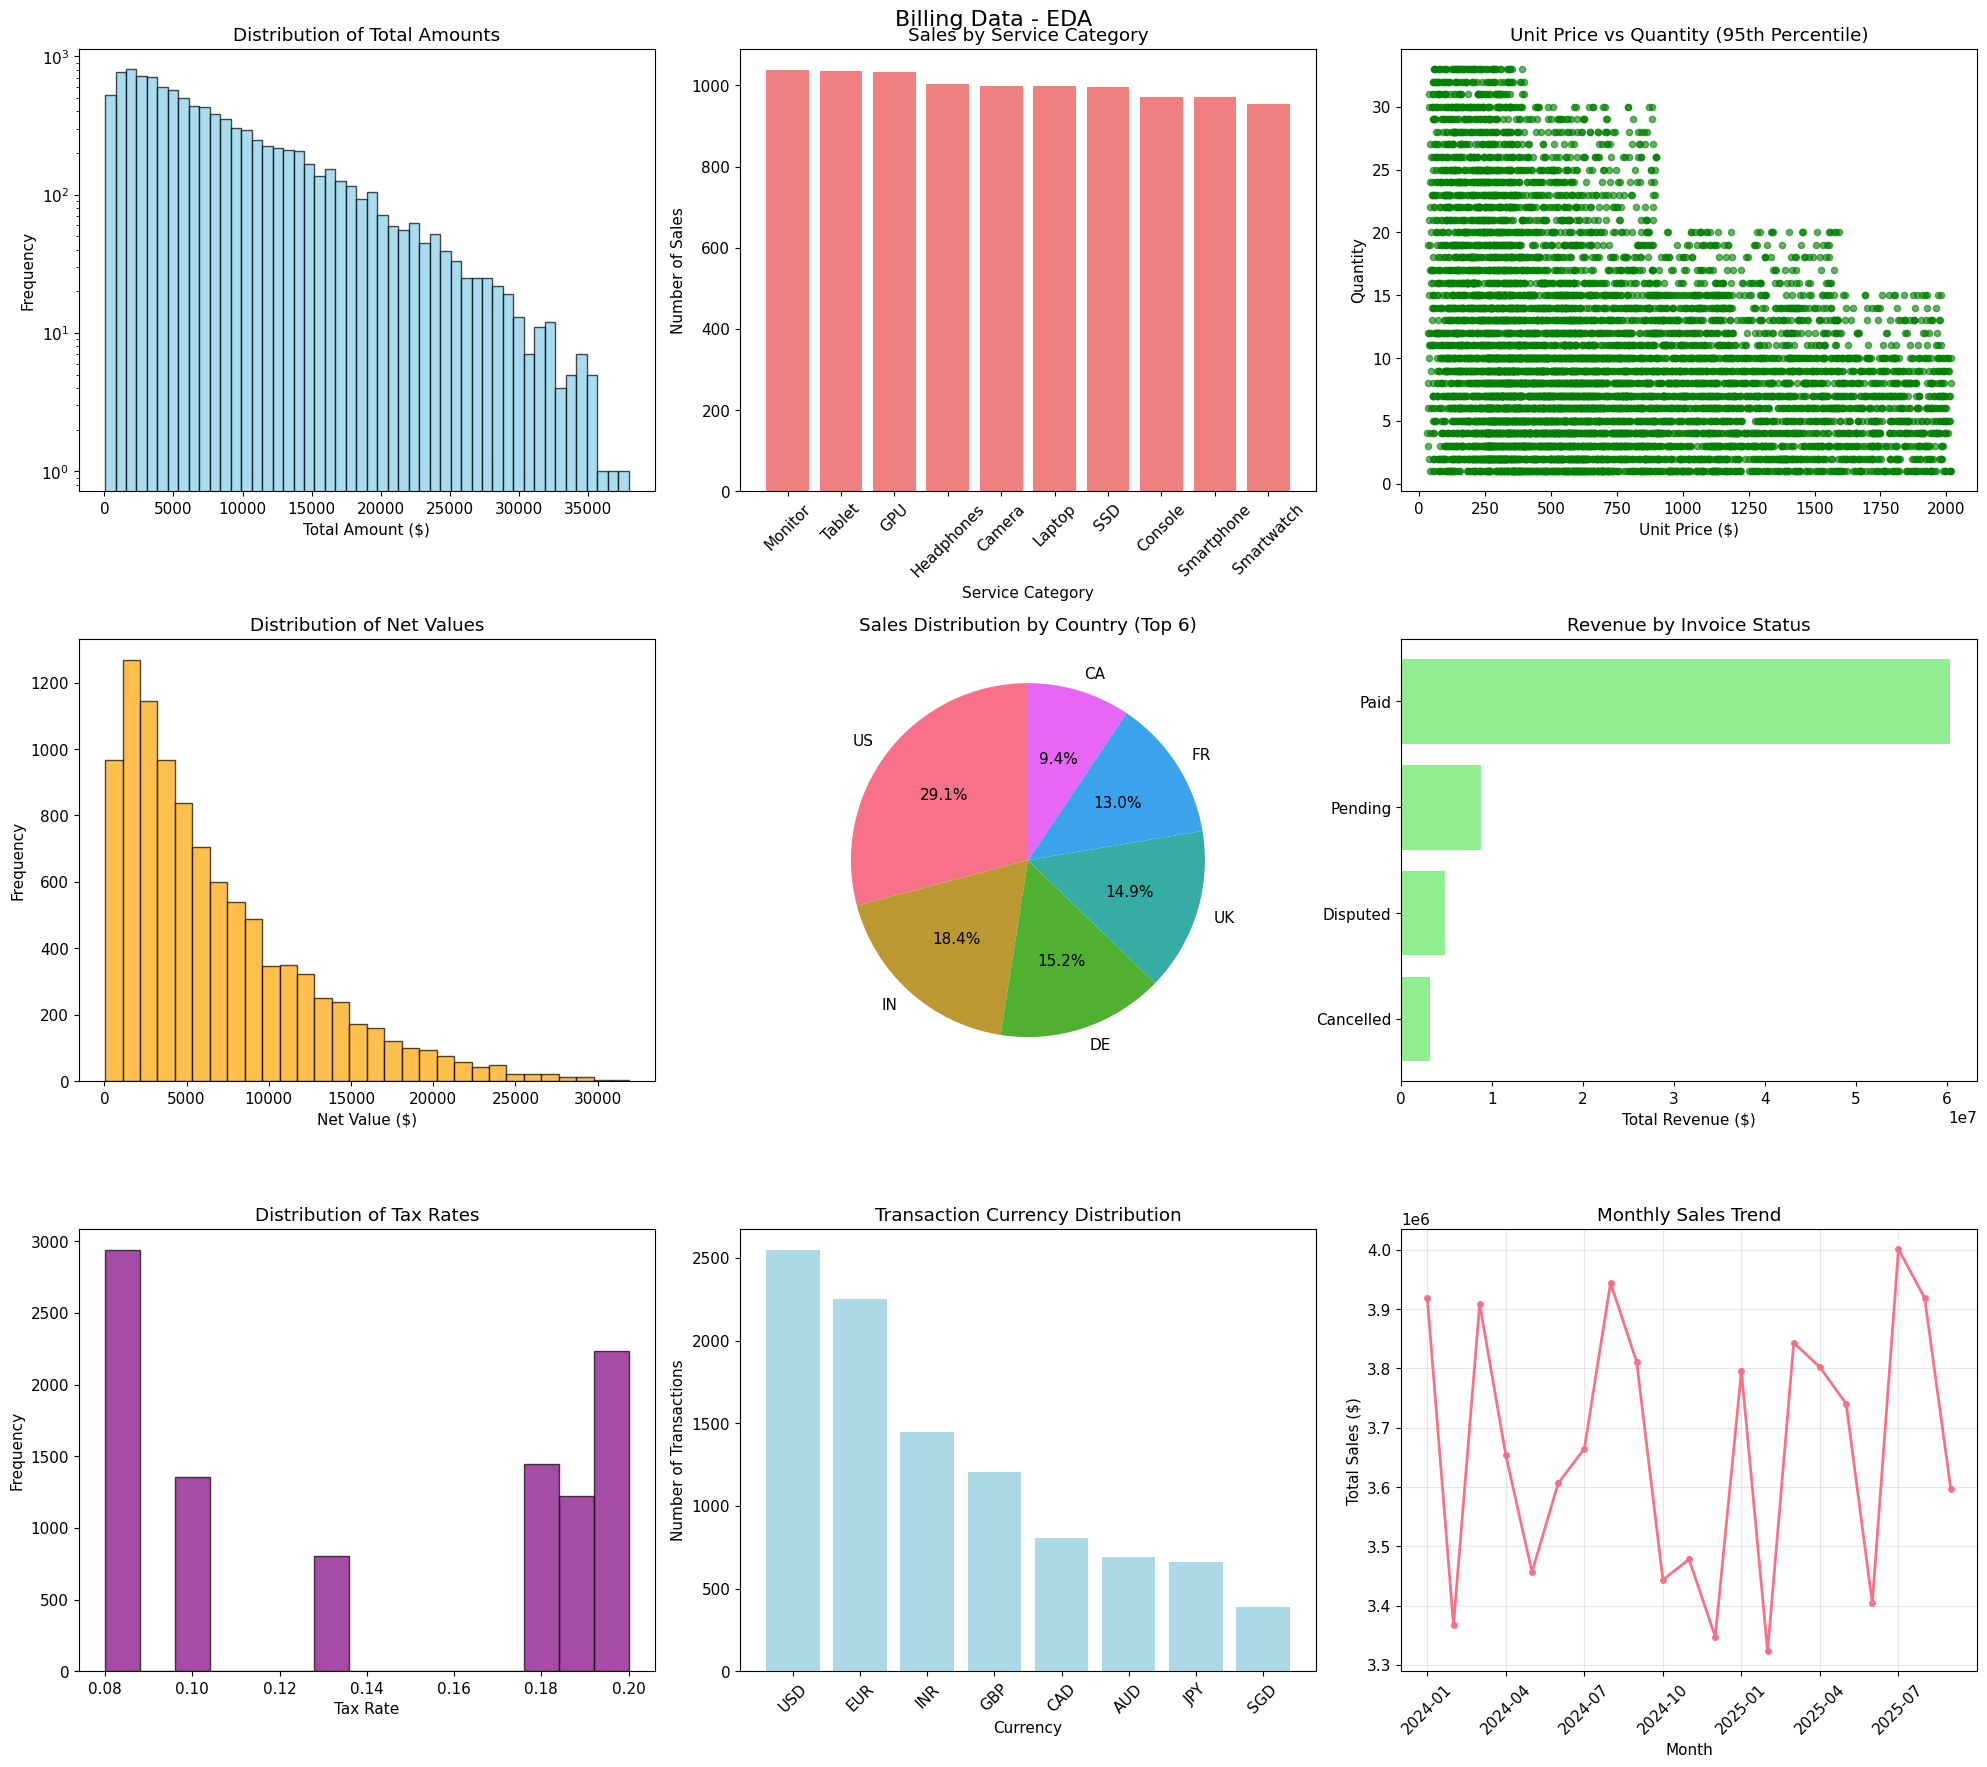


📊 Detailed Business Statistics:
💰 Revenue Metrics:
   Total Revenue: $77,024,757.94
   Average Order Value: $7,702.48
   Median Order Value: $5,808.01
   Revenue Range: $49.88 - $37,952.64

🛠️  Service Categories:
   Number of Categories: 10
   Top Category: Monitor (1038 sales)

👥 Customer Metrics:
   Unique Customers: 8,372
   Average Orders per Customer: 1.2

💵 Net Value Analysis:
   Average Net Value: $6750.00
   Average Tax Amount: $952.48

🌍 Geographic Distribution:
   US: 2,547 orders (25.5%)
   IN: 1,448 orders (14.5%)
   DE: 1,223 orders (12.2%)
   UK: 1,207 orders (12.1%)
   FR: 1,025 orders (10.2%)

💱 Currency Distribution:
   USD: 2,547 transactions (25.5%)
   EUR: 2,248 transactions (22.5%)
   INR: 1,448 transactions (14.5%)
   GBP: 1,207 transactions (12.1%)
   CAD: 805 transactions (8.1%)
   AUD: 693 transactions (6.9%)
   JPY: 661 transactions (6.6%)
   SGD: 391 transactions (3.9%)

📋 Invoice Status Distribution:
   Paid: 7,812 invoices (78.1%)
   Pending: 1,168 invoic

In [53]:
# Create visualization
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('Billing Data - EDA', fontsize=16, y=0.98)

# 1. Total Amount Distribution
if 'total_amount' in df.columns:
    axes[0, 0].hist(df['total_amount'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Distribution of Total Amounts')
    axes[0, 0].set_xlabel('Total Amount ($)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_yscale('log')
else:
    axes[0, 0].text(0.5, 0.5, 'Total Amount\nData Not Available', ha='center', va='center', 
                   transform=axes[0, 0].transAxes, fontsize=12)
    axes[0, 0].set_title('Distribution of Total Amounts')

# 2. Service Category Distribution
if 'service_category' in df.columns:
    category_counts = df['service_category'].value_counts()
    axes[0, 1].bar(category_counts.index, category_counts.values, color='lightcoral')
    axes[0, 1].set_title('Sales by Service Category')
    axes[0, 1].set_xlabel('Service Category')
    axes[0, 1].set_ylabel('Number of Sales')
    axes[0, 1].tick_params(axis='x', rotation=45)
else:
    axes[0, 1].text(0.5, 0.5, 'Service Category\nData Not Available', ha='center', va='center', 
                   transform=axes[0, 1].transAxes, fontsize=12)
    axes[0, 1].set_title('Sales by Service Category')

# 3. Unit Price vs Quantity Scatter
if 'unit_price' in df.columns and 'quantity' in df.columns:
    # Filter extreme outliers for better visualization
    price_95 = df['unit_price'].quantile(0.95)
    qty_95 = df['quantity'].quantile(0.95)
    filtered_df = df[(df['unit_price'] <= price_95) & (df['quantity'] <= qty_95)]
    
    axes[0, 2].scatter(filtered_df['unit_price'], filtered_df['quantity'], 
                      alpha=0.6, s=20, color='green')
    axes[0, 2].set_title('Unit Price vs Quantity (95th Percentile)')
    axes[0, 2].set_xlabel('Unit Price ($)')
    axes[0, 2].set_ylabel('Quantity')
else:
    axes[0, 2].text(0.5, 0.5, 'Price vs Quantity\nData Not Available', ha='center', va='center', 
                   transform=axes[0, 2].transAxes, fontsize=12)
    axes[0, 2].set_title('Unit Price vs Quantity')

# 4. Net Value Distribution
if 'net_value' in df.columns:
    axes[1, 0].hist(df['net_value'], bins=30, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 0].set_title('Distribution of Net Values')
    axes[1, 0].set_xlabel('Net Value ($)')
    axes[1, 0].set_ylabel('Frequency')
else:
    axes[1, 0].text(0.5, 0.5, 'Net Value\nData Not Available', ha='center', va='center', 
                   transform=axes[1, 0].transAxes, fontsize=12)
    axes[1, 0].set_title('Distribution of Net Values')

# 5. Country Sales Analysis
if 'country' in df.columns and 'total_amount' in df.columns:
    country_sales = df.groupby('country')['total_amount'].sum().sort_values(ascending=False)
    # Show top 6 countries for better visualization
    top_countries = country_sales.head(6)
    axes[1, 1].pie(top_countries.values, labels=top_countries.index, autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Sales Distribution by Country (Top 6)')
else:
    axes[1, 1].text(0.5, 0.5, 'Country Sales\nData Not Available', ha='center', va='center', 
                   transform=axes[1, 1].transAxes, fontsize=12)
    axes[1, 1].set_title('Sales Distribution by Country')

# 6. Invoice Status Analysis
if 'invoice_status' in df.columns and 'total_amount' in df.columns:
    status_revenue = df.groupby('invoice_status')['total_amount'].sum().sort_values(ascending=True)
    axes[1, 2].barh(status_revenue.index, status_revenue.values, color='lightgreen')
    axes[1, 2].set_title('Revenue by Invoice Status')
    axes[1, 2].set_xlabel('Total Revenue ($)')
else:
    axes[1, 2].text(0.5, 0.5, 'Invoice Status\nData Not Available', ha='center', va='center', 
                   transform=axes[1, 2].transAxes, fontsize=12)
    axes[1, 2].set_title('Revenue by Invoice Status')

# 7. Tax Rate Analysis
if 'tax_rate' in df.columns:
    axes[2, 0].hist(df['tax_rate'], bins=15, alpha=0.7, color='purple', edgecolor='black')
    axes[2, 0].set_title('Distribution of Tax Rates')
    axes[2, 0].set_xlabel('Tax Rate')
    axes[2, 0].set_ylabel('Frequency')
else:
    axes[2, 0].text(0.5, 0.5, 'Tax Rate Data\nNot Available', ha='center', va='center', 
                   transform=axes[2, 0].transAxes, fontsize=12)
    axes[2, 0].set_title('Distribution of Tax Rates')

# 8. Currency Analysis
if 'currency' in df.columns:
    currency_counts = df['currency'].value_counts()
    axes[2, 1].bar(currency_counts.index, currency_counts.values, color='lightblue')
    axes[2, 1].set_title('Transaction Currency Distribution')
    axes[2, 1].set_xlabel('Currency')
    axes[2, 1].set_ylabel('Number of Transactions')
    axes[2, 1].tick_params(axis='x', rotation=45)
else:
    axes[2, 1].text(0.5, 0.5, 'Currency\nData Not Available', ha='center', va='center', 
                   transform=axes[2, 1].transAxes, fontsize=12)
    axes[2, 1].set_title('Currency Distribution')

# 9. Monthly Sales Trend (if date column exists)
if 'invoice_date' in df.columns and 'total_amount' in df.columns:
    # Convert to datetime if not already
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    monthly_sales = df.groupby(df['invoice_date'].dt.to_period('M'))['total_amount'].sum()
    
    axes[2, 2].plot(range(len(monthly_sales)), monthly_sales.values, marker='o', linewidth=2, markersize=4)
    axes[2, 2].set_title('Monthly Sales Trend')
    axes[2, 2].set_xlabel('Month')
    axes[2, 2].set_ylabel('Total Sales ($)')
    axes[2, 2].grid(True, alpha=0.3)
    
    # Set x-axis labels
    month_labels = [str(p) for p in monthly_sales.index[::max(1, len(monthly_sales)//6)]]
    month_positions = range(0, len(monthly_sales), max(1, len(monthly_sales)//6))
    axes[2, 2].set_xticks(month_positions)
    axes[2, 2].set_xticklabels(month_labels, rotation=45)
else:
    axes[2, 2].text(0.5, 0.5, 'Date/Sales Trend\nData Not Available', ha='center', va='center', 
                   transform=axes[2, 2].transAxes, fontsize=12)
    axes[2, 2].set_title('Monthly Sales Trend')

plt.tight_layout()
plt.show()

# Generate detailed statistics
print(f"\n📊 Detailed Business Statistics:")
print("="*50)

# Revenue statistics
if 'total_amount' in df.columns:
    total_revenue = df['total_amount'].sum()
    avg_order_value = df['total_amount'].mean()
    median_order_value = df['total_amount'].median()
    
    print(f"💰 Revenue Metrics:")
    print(f"   Total Revenue: ${total_revenue:,.2f}")
    print(f"   Average Order Value: ${avg_order_value:,.2f}")
    print(f"   Median Order Value: ${median_order_value:,.2f}")
    print(f"   Revenue Range: ${df['total_amount'].min():,.2f} - ${df['total_amount'].max():,.2f}")

# Product/Service statistics
if 'service_category' in df.columns:
    print(f"\n🛠️  Service Categories:")
    print(f"   Number of Categories: {df['service_category'].nunique()}")
    print(f"   Top Category: {df['service_category'].value_counts().index[0]} ({df['service_category'].value_counts().iloc[0]} sales)")

# Customer statistics
if 'customer_id' in df.columns:
    unique_customers = df['customer_id'].nunique()
    avg_orders_per_customer = len(df) / unique_customers
    print(f"\n👥 Customer Metrics:")
    print(f"   Unique Customers: {unique_customers:,}")
    print(f"   Average Orders per Customer: {avg_orders_per_customer:.1f}")

# Net value analysis
if 'net_value' in df.columns:
    avg_net_value = df['net_value'].mean()
    print(f"\n💵 Net Value Analysis:")
    print(f"   Average Net Value: ${avg_net_value:.2f}")
    if 'total_amount' in df.columns:
        avg_tax_amount = (df['total_amount'] - df['net_value']).mean()
        print(f"   Average Tax Amount: ${avg_tax_amount:.2f}")

# Geographic analysis
if 'country' in df.columns:
    print(f"\n🌍 Geographic Distribution:")
    for country in df['country'].value_counts().head(5).index:
        count = df['country'].value_counts()[country]
        percentage = count / len(df) * 100
        print(f"   {country}: {count:,} orders ({percentage:.1f}%)")
elif 'region' in df.columns:
    print(f"\n🌍 Geographic Distribution:")
    for region in df['region'].value_counts().index:
        count = df['region'].value_counts()[region]
        percentage = count / len(df) * 100
        print(f"   {region}: {count:,} orders ({percentage:.1f}%)")

# Currency analysis
if 'currency' in df.columns:
    print(f"\n💱 Currency Distribution:")
    for currency in df['currency'].value_counts().index:
        count = df['currency'].value_counts()[currency]
        percentage = count / len(df) * 100
        print(f"   {currency}: {count:,} transactions ({percentage:.1f}%)")

# Invoice status analysis
if 'invoice_status' in df.columns:
    print(f"\n📋 Invoice Status Distribution:")
    for status in df['invoice_status'].value_counts().index:
        count = df['invoice_status'].value_counts()[status]
        percentage = count / len(df) * 100
        print(f"   {status}: {count:,} invoices ({percentage:.1f}%)")

# Potential anomaly indicators
print(f"\n⚠️ Potential Anomaly Indicators:")
anomaly_indicators = []

if 'unit_price' in df.columns:
    negative_prices = (df['unit_price'] < 0).sum()
    if negative_prices > 0:
        anomaly_indicators.append(f"• {negative_prices} negative unit prices")

if 'quantity' in df.columns:
    zero_qty = (df['quantity'] == 0).sum()
    extreme_qty = (df['quantity'] > df['quantity'].quantile(0.99)).sum()
    if zero_qty > 0:
        anomaly_indicators.append(f"• {zero_qty} zero quantities")
    if extreme_qty > 0:
        anomaly_indicators.append(f"• {extreme_qty} extreme quantities (>99th percentile)")

if 'net_value' in df.columns and 'total_amount' in df.columns:
    inconsistent_net = ((df['net_value'] > df['total_amount']) | (df['net_value'] < 0)).sum()
    if inconsistent_net > 0:
        anomaly_indicators.append(f"• {inconsistent_net} inconsistent net values")

if 'total_amount' in df.columns:
    zero_amounts = (df['total_amount'] <= 0).sum()
    if zero_amounts > 0:
        anomaly_indicators.append(f"• {zero_amounts} zero or negative total amounts")

# Check for tax calculation consistency
if 'tax_amount' in df.columns and 'tax_rate' in df.columns and 'net_value' in df.columns:
    expected_tax = df['net_value'] * df['tax_rate']
    tax_diff = abs(df['tax_amount'] - expected_tax)
    inconsistent_tax = (tax_diff > 0.01).sum()  # Allow small rounding differences
    if inconsistent_tax > 0:
        anomaly_indicators.append(f"• {inconsistent_tax} inconsistent tax calculations")

if anomaly_indicators:
    for indicator in anomaly_indicators:
        print(f"   {indicator}")
else:
    print("   ✅ No obvious anomaly indicators found in basic analysis")

print(f"\n📋 EDA Summary:")
print(f"   Records analyzed: {len(df):,}")
print(f"   Features analyzed: {len(df.columns)}")
print(f"   Time period: {df['invoice_date'].dt.date.min()} to {df['invoice_date'].dt.date.max()}" if 'invoice_date' in df.columns else "   Time period: Not available")

### 5.1. Correlation Analysis

Analyze relationships between numerical features to understand dependencies and potential multicollinearity.

🔗 Correlation Analysis
📊 Analyzing correlations for 6 numerical features:
Features: quantity, unit_price, net_value, tax_rate, tax_amount, total_amount


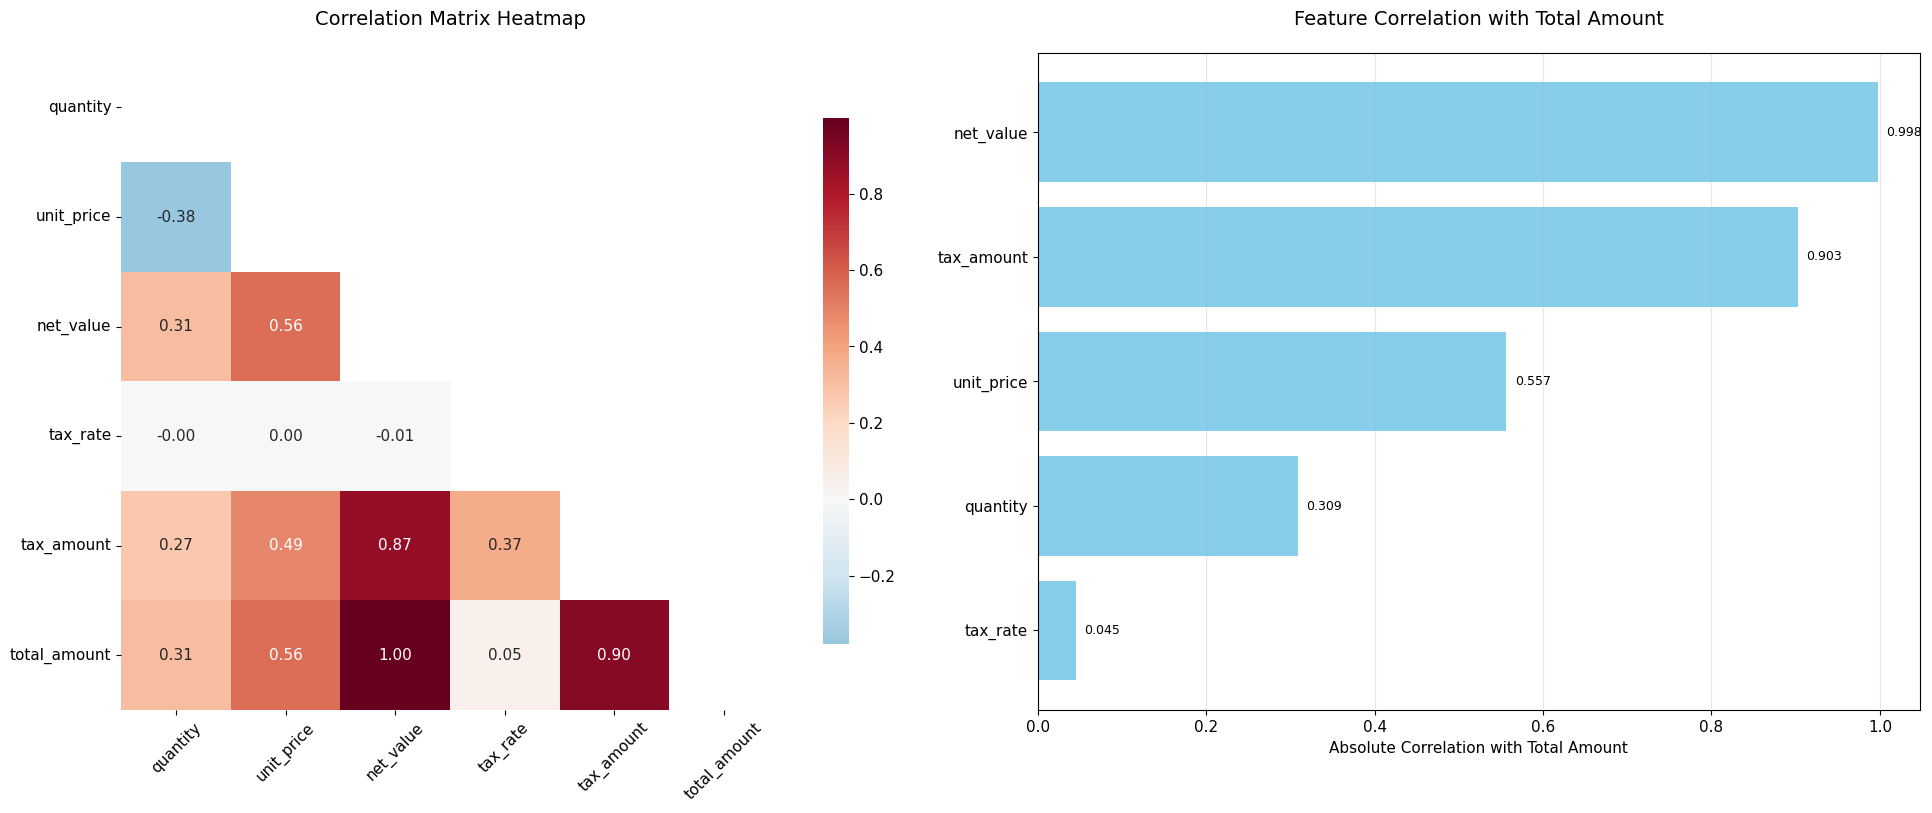


🔍 Strong Correlations (|r| > 0.7):
   • net_value ↔ tax_amount: 0.870 (positive)
   • net_value ↔ total_amount: 0.998 (positive)
   • tax_amount ↔ total_amount: 0.903 (positive)

📊 Moderate Correlations (0.5 < |r| < 0.7):
   • unit_price ↔ net_value: 0.558 (positive)
   • unit_price ↔ total_amount: 0.557 (positive)

💼 Business Insights from Correlations:
   • Net Value ↔ Total Amount: 0.998 (Expected: high positive)
   • Tax Amount ↔ Net Value: 0.870 (Expected: positive)
   • Quantity ↔ Total Amount: 0.309 (Expected: positive)
   • Unit Price ↔ Total Amount: 0.557 (Expected: positive)

⚠️ Multicollinearity Assessment:
   🚨 High multicollinearity detected (|r| > 0.9):
      • net_value ↔ total_amount: 0.998
      • tax_amount ↔ total_amount: 0.903
   💡 Consider removing one of the highly correlated features for anomaly detection

📈 Correlation Matrix Summary:
   • Mean absolute correlation: 0.404
   • Max correlation: 0.998
   • Min correlation: -0.380
   • Std of correlations: 0.375



In [54]:
# Correlation Analysis
print("🔗 Correlation Analysis")
print("="*50)

# Select numerical columns for correlation analysis
numerical_cols_for_corr = []
for col in df.columns:
    if df[col].dtype in ['int64', 'float64', 'int32', 'float32']:
        numerical_cols_for_corr.append(col)

print(f"📊 Analyzing correlations for {len(numerical_cols_for_corr)} numerical features:")
print(f"Features: {', '.join(numerical_cols_for_corr)}")

if len(numerical_cols_for_corr) >= 2:
    # Calculate correlation matrix
    correlation_matrix = df[numerical_cols_for_corr].corr()
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    # 1. Correlation Heatmap
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True,
                fmt='.2f',
                cbar_kws={"shrink": .8},
                ax=axes[0])
    axes[0].set_title('Correlation Matrix Heatmap', fontsize=14, pad=20)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].tick_params(axis='y', rotation=0)
    
    # 2. Correlation with Total Amount (if available)
    if 'total_amount' in numerical_cols_for_corr:
        total_amount_corr = correlation_matrix['total_amount'].drop('total_amount').abs().sort_values(ascending=True)
        
        axes[1].barh(range(len(total_amount_corr)), total_amount_corr.values, color='skyblue')
        axes[1].set_yticks(range(len(total_amount_corr)))
        axes[1].set_yticklabels(total_amount_corr.index)
        axes[1].set_xlabel('Absolute Correlation with Total Amount')
        axes[1].set_title('Feature Correlation with Total Amount', fontsize=14, pad=20)
        axes[1].grid(axis='x', alpha=0.3)
        
        # Add correlation values as text
        for i, v in enumerate(total_amount_corr.values):
            axes[1].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)
    else:
        axes[1].text(0.5, 0.5, 'Total Amount\nNot Available\nfor Correlation Analysis', 
                    ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
        axes[1].set_title('Feature Correlation with Total Amount', fontsize=14, pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Identify strong correlations
    print(f"\n🔍 Strong Correlations (|r| > 0.7):")
    strong_correlations = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.7:
                feature1 = correlation_matrix.columns[i]
                feature2 = correlation_matrix.columns[j]
                strong_correlations.append((feature1, feature2, corr_value))
    
    if strong_correlations:
        for feature1, feature2, corr in strong_correlations:
            direction = "positive" if corr > 0 else "negative"
            print(f"   • {feature1} ↔ {feature2}: {corr:.3f} ({direction})")
    else:
        print("   ✅ No strong correlations (|r| > 0.7) found")
    
    # Identify moderate correlations
    print(f"\n📊 Moderate Correlations (0.5 < |r| < 0.7):")
    moderate_correlations = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = correlation_matrix.iloc[i, j]
            if 0.5 < abs(corr_value) < 0.7:
                feature1 = correlation_matrix.columns[i]
                feature2 = correlation_matrix.columns[j]
                moderate_correlations.append((feature1, feature2, corr_value))
    
    if moderate_correlations:
        for feature1, feature2, corr in moderate_correlations:
            direction = "positive" if corr > 0 else "negative"
            print(f"   • {feature1} ↔ {feature2}: {corr:.3f} ({direction})")
    else:
        print("   ✅ No moderate correlations (0.5 < |r| < 0.7) found")
    
    # Business interpretation of key correlations
    print(f"\n💼 Business Insights from Correlations:")
    
    # Check specific business-relevant correlations
    business_correlations = []
    
    if 'net_value' in correlation_matrix.columns and 'total_amount' in correlation_matrix.columns:
        corr = correlation_matrix.loc['net_value', 'total_amount']
        business_correlations.append(f"• Net Value ↔ Total Amount: {corr:.3f} (Expected: high positive)")
    
    if 'tax_amount' in correlation_matrix.columns and 'net_value' in correlation_matrix.columns:
        corr = correlation_matrix.loc['tax_amount', 'net_value']
        business_correlations.append(f"• Tax Amount ↔ Net Value: {corr:.3f} (Expected: positive)")
    
    if 'quantity' in correlation_matrix.columns and 'total_amount' in correlation_matrix.columns:
        corr = correlation_matrix.loc['quantity', 'total_amount']
        business_correlations.append(f"• Quantity ↔ Total Amount: {corr:.3f} (Expected: positive)")
    
    if 'unit_price' in correlation_matrix.columns and 'total_amount' in correlation_matrix.columns:
        corr = correlation_matrix.loc['unit_price', 'total_amount']
        business_correlations.append(f"• Unit Price ↔ Total Amount: {corr:.3f} (Expected: positive)")
    
    if business_correlations:
        for corr_info in business_correlations:
            print(f"   {corr_info}")
    
    # Multicollinearity warning
    print(f"\n⚠️ Multicollinearity Assessment:")
    high_corr_pairs = [(f1, f2, corr) for f1, f2, corr in strong_correlations if abs(corr) > 0.9]
    if high_corr_pairs:
        print("   🚨 High multicollinearity detected (|r| > 0.9):")
        for feature1, feature2, corr in high_corr_pairs:
            print(f"      • {feature1} ↔ {feature2}: {corr:.3f}")
        print("   💡 Consider removing one of the highly correlated features for anomaly detection")
    else:
        print("   ✅ No severe multicollinearity detected")
    
    # Correlation summary statistics
    print(f"\n📈 Correlation Matrix Summary:")
    correlation_values = correlation_matrix.values
    upper_triangle = correlation_values[np.triu_indices_from(correlation_values, k=1)]
    
    print(f"   • Mean absolute correlation: {np.mean(np.abs(upper_triangle)):.3f}")
    print(f"   • Max correlation: {np.max(upper_triangle):.3f}")
    print(f"   • Min correlation: {np.min(upper_triangle):.3f}")
    print(f"   • Std of correlations: {np.std(upper_triangle):.3f}")
    
    # Store correlation matrix for later use
    correlation_results = {
        'correlation_matrix': correlation_matrix,
        'strong_correlations': strong_correlations,
        'moderate_correlations': moderate_correlations
    }
    
    print(f"\n✅ Correlation analysis completed!")
    
else:
    print("⚠️ Insufficient numerical features for correlation analysis")
    correlation_results = None

## 6. Data Preprocessing and Feature Engineering

In [55]:
# Advanced Feature Engineering for Anomaly Detection
print("🔧 Advanced Feature Engineering for Billing Anomaly Detection")
print("="*80)

# Start with our cleaned anomaly detection dataset
ml_df = anomaly_df.copy()

print(f"📊 Starting with {len(ml_df)} records and {len(ml_df.columns)} features")

# 1. Create business validation features
print(f"\n💼 Creating Business Validation Features:")

# Price consistency checks
if all(col in ml_df.columns for col in ['unit_price', 'quantity', 'net_value']):
    ml_df['price_consistency_score'] = 1 - (ml_df['gross_amount_diff'] / (ml_df['net_value'] + 1))
    print("✅ Price consistency score created")

# 2. Create only the most important statistical features
print(f"\n📊 Creating Statistical Features (Limited Selection):")

# Only create Z-scores for the most critical features
critical_numerical_cols = ['total_amount', 'net_value', 'tax_amount']
for col in critical_numerical_cols:
    if col in ml_df.columns:
        ml_df[f'{col}_zscore'] = zscore(ml_df[col])
        print(f"✅ Z-score created for {col}")

# Only percentile rank for total_amount (most important for anomaly detection)
if 'total_amount' in ml_df.columns:
    ml_df['total_amount_percentile'] = ml_df['total_amount'].rank(pct=True)
    print("✅ Percentile rank created for total_amount")

# 3. Create only essential ratio features
print(f"\n🔢 Creating Essential Ratio Features:")

# Tax to net amount ratio (critical for tax validation)
if 'tax_amount' in ml_df.columns and 'net_value' in ml_df.columns:
    ml_df['tax_to_net_ratio'] = ml_df['tax_amount'] / (ml_df['net_value'] + 1)
    print("✅ Tax to net ratio created")

# 4. Handle categorical variables (only encode, skip statistics)
print(f"\n🏷️ Processing Categorical Variables (Encoding Only):")

categorical_columns = ['service_category', 'country', 'currency', 'invoice_status']
categorical_to_encode = [col for col in categorical_columns if col in ml_df.columns]

# Use label encoding for categorical variables
label_encoders = {}
for col in categorical_to_encode:
    le = LabelEncoder()
    ml_df[f'{col}_encoded'] = le.fit_transform(ml_df[col].astype(str))
    label_encoders[col] = le
    print(f"✅ Label encoded: {col}")

# 5. Create only essential temporal features
if 'invoice_date' in df.columns:
    print(f"\n📅 Creating Essential Temporal Features:")
    
    temp_date = pd.to_datetime(df['invoice_date'])
    ml_df = ml_df.reset_index(drop=True)
    temp_date = temp_date.iloc[:len(ml_df)]
    
    # Only keep month and weekend indicator (most relevant for anomaly patterns)
    ml_df['month'] = temp_date.dt.month
    ml_df['is_weekend'] = (temp_date.dt.dayofweek >= 5).astype(int)
    
    print("✅ Essential temporal features created")

# 6. Remove original categorical columns
columns_to_remove = []
for col in categorical_to_encode:
    if col in ml_df.columns:
        columns_to_remove.append(col)

ml_df = ml_df.drop(columns=columns_to_remove)
print(f"✅ Removed original categorical columns: {columns_to_remove}")

# 7. Handle any remaining missing values
print(f"\n🧹 Final Data Cleaning:")
ml_df = ml_df.fillna(0)
ml_df = ml_df.replace([np.inf, -np.inf], 0)
print(f"✅ Cleaned missing and infinite values")

# 8. Feature scaling and prioritized selection
print(f"\n⚖️ Feature Scaling and Prioritization:")

# Separate features for scaling
numeric_feature_columns = []
for col in ml_df.columns:
    if col not in ['invoice_id', 'customer_id', 'product_id']:
        if ml_df[col].dtype in ['int64', 'float64', 'int32', 'float32']:
            numeric_feature_columns.append(col)

print(f"📊 Total available numeric features: {len(numeric_feature_columns)}")

# 9. Intelligent Feature Prioritization
print(f"\n🎯 Intelligent Feature Prioritization:")

# Define feature importance tiers for billing anomaly detection
feature_priority = {
    'Critical': [
        'total_amount', 'net_value', 'tax_amount', 'unit_price', 'quantity',
        'total_amount_diff', 'tax_amount_diff', 'gross_amount_diff'
    ],
    'Important': [
        'tax_rate', 'total_amount_zscore', 'net_value_zscore', 'tax_amount_zscore',
        'total_amount_percentile', 'tax_to_net_ratio', 'price_consistency_score'
    ],
    'Useful': [
        'service_category_encoded', 'country_encoded', 'currency_encoded', 
        'invoice_status_encoded', 'month', 'is_weekend'
    ]
}

# Select features based on priority and availability
selected_features = []
feature_scores = {}

for priority, features in feature_priority.items():
    available_features = [f for f in features if f in numeric_feature_columns]
    selected_features.extend(available_features)
    
    # Assign priority scores
    if priority == 'Critical':
        score = 3
    elif priority == 'Important':
        score = 2
    else:
        score = 1
    
    for f in available_features:
        feature_scores[f] = score
    
    print(f"   📊 {priority} features: {len(available_features)} selected")
    if available_features:
        print(f"      • {', '.join(available_features[:5])}" + 
              (f" ... and {len(available_features)-5} more" if len(available_features) > 5 else ""))

# Limit to top 15 most important features
MAX_FEATURES = 15
if len(selected_features) > MAX_FEATURES:
    # Sort by priority score and feature importance
    if 'total_amount' in ml_df.columns:
        # Calculate correlation with total_amount for tie-breaking
        correlations = {}
        for feature in selected_features:
            if feature in ml_df.columns:
                corr = abs(ml_df[feature].corr(ml_df['total_amount']))
                correlations[feature] = corr if not pd.isna(corr) else 0
        
        # Sort by priority score first, then by correlation
        selected_features = sorted(selected_features, 
                                 key=lambda x: (feature_scores.get(x, 0), correlations.get(x, 0)), 
                                 reverse=True)[:MAX_FEATURES]
    else:
        selected_features = selected_features[:MAX_FEATURES]
    
    print(f"\n🔥 Reduced to top {MAX_FEATURES} features for optimal performance")

# Create final feature set
final_features = [f for f in selected_features if f in numeric_feature_columns]

# Standard scaling for selected features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ml_df[final_features])
X_final = pd.DataFrame(X_scaled, columns=final_features, index=ml_df.index)

print(f"✅ Scaled {len(final_features)} prioritized features")

# Remove any remaining low-variance features
feature_variances = X_final.var()
low_variance_features = feature_variances[feature_variances < 0.01].index.tolist()

if low_variance_features:
    print(f"⚠️ Removing {len(low_variance_features)} low-variance features:")
    for feat in low_variance_features:
        print(f"   • {feat} (variance: {feature_variances[feat]:.4f})")
    
    high_variance_features = [f for f in final_features if f not in low_variance_features]
    X_final = X_final[high_variance_features]

# Final dataset summary
print(f"\n📋 Optimized Dataset Summary:")
print("="*50)
print(f"📊 Records: {len(X_final):,}")
print(f"🎯 Features: {len(X_final.columns)} (reduced from {len(numeric_feature_columns)})")
print(f"📈 Feature variance range: {X_final.var().min():.4f} - {X_final.var().max():.4f}")

print(f"\n🏆 Final Selected Features:")
for i, feature in enumerate(X_final.columns, 1):
    priority = 'Critical' if feature_scores.get(feature, 0) == 3 else 'Important' if feature_scores.get(feature, 0) == 2 else 'Useful'
    print(f"   {i:2d}. {feature} ({priority})")

# Display feature importance estimation
if 'total_amount' in ml_df.columns:
    print(f"\n🎯 Feature Correlation with Total Amount:")
    total_amount_series = ml_df['total_amount'].iloc[:len(X_final)]
    correlations = abs(X_final.corrwith(total_amount_series)).sort_values(ascending=False)
    for i, (feature, corr) in enumerate(correlations.items(), 1):
        print(f"   {i:2d}. {feature}: {corr:.3f}")

print(f"\n✅ Feature engineering completed! Optimized dataset ready for anomaly detection.")
print(f"🚀 Reduced features by {((len(numeric_feature_columns) - len(X_final.columns)) / len(numeric_feature_columns) * 100):.1f}% while retaining most important information")

🔧 Advanced Feature Engineering for Billing Anomaly Detection
📊 Starting with 10000 records and 19 features

💼 Creating Business Validation Features:
✅ Price consistency score created

📊 Creating Statistical Features (Limited Selection):
✅ Z-score created for total_amount
✅ Z-score created for net_value
✅ Z-score created for tax_amount
✅ Percentile rank created for total_amount

🔢 Creating Essential Ratio Features:
✅ Tax to net ratio created

🏷️ Processing Categorical Variables (Encoding Only):
✅ Label encoded: service_category
✅ Label encoded: country
✅ Label encoded: currency
✅ Label encoded: invoice_status

📅 Creating Essential Temporal Features:
✅ Essential temporal features created
✅ Removed original categorical columns: ['service_category', 'country', 'currency', 'invoice_status']

🧹 Final Data Cleaning:
✅ Cleaned missing and infinite values

⚖️ Feature Scaling and Prioritization:
📊 Total available numeric features: 24

🎯 Intelligent Feature Prioritization:
   📊 Critical features: